
# Version 2 - Fundamental
## w uncertainty of RES and w\o clearing fee
## Risk / Risk-Averse Scenario
### Author: Junhyeok Kim

In [1]:
# Import the library

import os
import pandas as pd
import numpy as np
import sys

import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})

In [2]:
# Define the Variables
BASE_DIR = os.getcwd()
os.chdir("../")
path = os.getcwd() 
sys.path.append(path) # 폴더 한 단계 위에서 file import 하기 위해서 sys path 설정

from aggregator import aggregator
from gurobiMILP import gurobi_MILP
from draw_fig import Opt_Bid_Plot

In [3]:
# Data generated from the date 221030 
wt_dataset = pd.read_excel(f"{path}/data/비중앙 실적.xlsx", 1, header=1)
wt_data = wt_dataset.iloc[-2, 1:-2].values
wt_profile = wt_data / np.max(wt_data)
wt_profile = wt_profile.astype(float)
wt_profile = np.maximum(wt_profile, 1e-6)

pv_dataset = pd.read_excel(f"{path}/data/비중앙 실적.xlsx", 2, header=1)
pv_data = pv_dataset.iloc[-2, 1:-2].values
pv_profile = pv_data / np.max(pv_data).astype(float)
pv_profile = pv_profile.astype(float)
pv_profile = np.maximum(pv_profile, 1e-6)

da_smp_dataset = pd.read_excel(f"{path}/data/smp_jeju_2022.xlsx", header=1)
da_smp_data = da_smp_dataset.loc[da_smp_dataset['구분']== 20221030]
da_smp_profile= da_smp_data.iloc[0,1:1+24].values
da_smp_profile = da_smp_profile.astype(float)

print("Display WT, PV, DA_SMP Profile")
display(wt_profile, pv_profile, da_smp_profile)

Display WT, PV, DA_SMP Profile


array([ 0.251355,  0.290609,  0.392466,  0.452870,  0.474049,  0.541380,
        0.713243,  0.707066,  0.772422,  0.544620,  0.079141,  0.126149,
        0.108657,  0.122997,  0.196914,  0.573056,  0.869784,  1.000000,
        0.998045,  0.834849,  0.742808,  0.654308,  0.603574,  0.747760])

array([ 0.000423,  0.000407,  0.000374,  0.000363,  0.000358,  0.000363,
        0.000477,  0.070437,  0.386254,  0.709651,  0.904545,  1.000000,
        0.998997,  0.907256,  0.797912,  0.515076,  0.230750,  0.025176,
        0.003318,  0.002179,  0.000001,  0.000092,  0.000461,  0.000455])

array([ 258.300000,  232.600000,  213.100000,  207.750000,  213.250000,
        213.250000,  213.100000,  212.800000,  212.650000,  213.760000,
        204.700000,  211.140000,  211.140000,  210.510000,  208.000000,
        207.590000,  210.510000,  257.690000,  283.370000,  258.120000,
        258.160000,  257.800000,  258.280000,  257.040000])

In [4]:
# Define the Parameters

# case_dict: Generate various scenario
# res_var: Define the WT and PV as variables [True] or parameters [False]
# case:
    # case 1 : w/o uncertainty
    # case 2 : w uncertainty with +- 8% proportionally , robust (rise-averse)
    
    #res_var: Determine whether res (WT, PV) as variable or not
    #UNIT_TIME: 1 -> 1 hour
case_dict = {'res_var': True, 'case':2, 'UNIT_TIME': 1}
nTimeslot = int(24 / case_dict['UNIT_TIME'])
char_ess = {'initSOC':0.5, 'termSOC':0.5, 'minSOC':0.2, 'maxSOC':0.8, 'efficiency':0.95}

model_dict = {'nVPP':1, 'da_smp': da_smp_profile, 'nTimeslot': nTimeslot}

# Once, set te PV, WT, SMP uncertainties identically in each time (PV: 5%, WT: 10%, SMP: 10%)
uncertainty_dict = {'pv': np.ones(nTimeslot)*0.05 , 'wt': np.ones(nTimeslot)*0.10, 'smp':np.ones(nTimeslot)*0.10}


if case_dict['case']==2:
    
    model_dict['uncertainty'] = uncertainty_dict
    case_dict['bid_type'] = 'risky'
    
elif case_dict['case'] == 1:
    
    uncertainty_dict = {'pv': np.zeros(nTimeslot), 'wt': np.zeros(nTimeslot), 'smp':np.zeros(nTimeslot)}
    model_dict['uncertainty'] = uncertainty_dict
    
# Set Up VPP  #Unit: kW

vpp_list = []
for i in range(model_dict['nVPP']):
    nGen_dict = {'WT':1,'PV':2, 'ESS':1}
    
    wt_list = [1000]
    pv_list = [3000, 2000]
    ess_list = [1000]
    capacity_list = [3000] 
    max_list = [wt_list, pv_list, ess_list, capacity_list]
    
    agg_dict = {'name': f'cvpp{i+1}', 'code': f'xds{i+1}', 'gen':nGen_dict,
                'profile': [wt_profile, pv_profile]}
    vpp_list.append(aggregator(agg_dict, char_ess, model_dict))
    vpp_list[i].set_der_power(max_list)
vpp_list[0].get_res_table()

,name,type,number,min_power,max_power,capacity
0,WT1_cvpp1,WT,1,0,1000,NaN
1,PV2_cvpp1,PV,2,0,3000,NaN
2,PV3_cvpp1,PV,3,0,2000,NaN
3,ESS4_cvpp1,ESS,4,-1000,1000,3000.0


## Run the Risky Scenario
## opt_bid Sets (Only maximize the profile with uncertainty)

### Uncertainty -> PV: +- 5%, WT: +-10%, SMP: +- 10% for all timeslots
### Set this on gurobi_MILP -> add_Variables

In [5]:
# Gurobi Optimization Model
opt_bid = gurobi_MILP('opt bid', vpp_list[0], model_dict, case_dict)
opt_bid.add_Parameters()
opt_bid.add_Variables()
opt_bid.add_bid_constraints()
opt_bid.add_smp_constraints()
opt_bid.add_res_constraints()
opt_bid.add_ess_contraints()
opt_bid.set_Objectives()

mip_gap = 0.0001
feas_tol = 1e-4
sol, obj = opt_bid.solve([mip_gap, feas_tol])


Assign the P_wt
Assign the P_pv
Does not Cosidered alpha
ADD smp constraints as fixed
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 217 rows, 288 columns and 1680 nonzeros
Model fingerprint: 0x1316194d
Variable types: 240 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [3e-04, 3e+03]
  Objective range  [2e+02, 3e+02]
  Bounds range     [5e-02, 7e+03]
  RHS range        [2e-03, 3e+03]
Found heuristic solution: objective 9250706.0350
Presolve removed 122 rows and 214 columns
Presolve time: 0.00s
Presolved: 95 rows, 74 columns, 1080 nonzeros
Found heuristic solution: objective 1.054122e+07
Variable types: 50 continuous, 24 integer (24 binary)

Root relaxation: objective 1.061390e+07, 16 iterations, 0.00 seconds (0.00 wor

In [6]:
P_dict, U_dict = opt_bid.get_sol()
display(P_dict)

#P_dict: The results of the variables

{'bid': array([ 1133.710105,  321.804573,  433.676691,  500.064302,  523.332628,
         597.424966,  787.072269,  1147.564040,  2877.498581,  4324.747615,
         3835.916853,  5388.764094,  5364.257855,  4898.388850,
         4405.642425,  2439.774356,  2168.198316,  1232.172131,
         1970.267066,  929.775547,  817.094295,  720.222916,  666.350838,
         824.926730]),
 'essDis': array([[ 855.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  855.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000]]),
 'essChg': array([[ 0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  1000.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  894.736842,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,

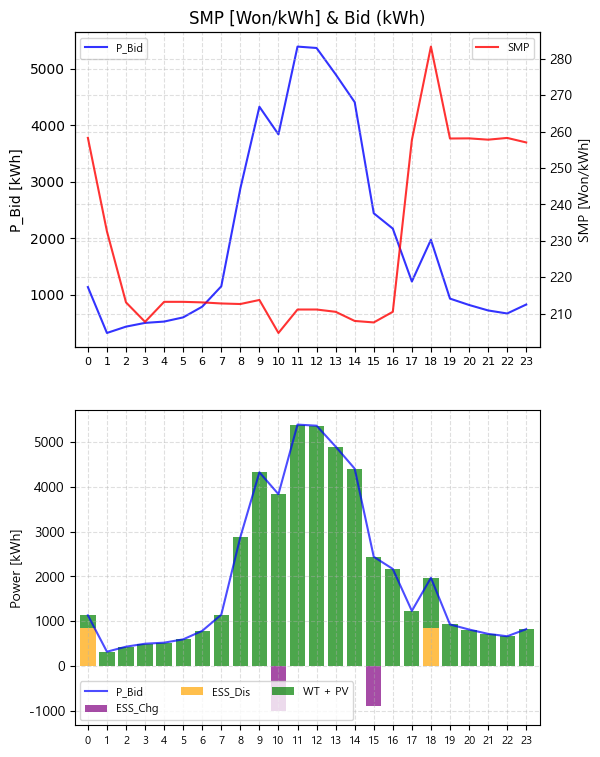

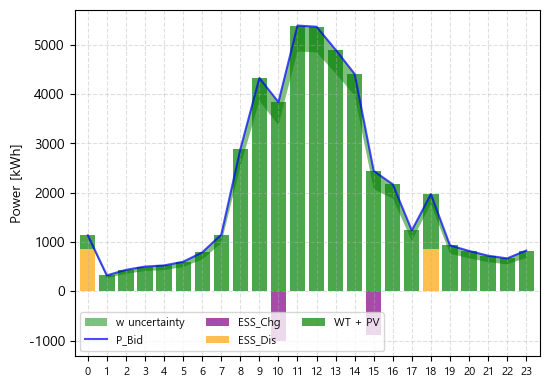

In [7]:
# Draw the Plots

bid_plot = Opt_Bid_Plot(vpp_list, opt_bid, model_dict, case_dict, path)
bid_plot.make_plot(P_dict)

## Run the Risk-Averse Scenario
## opt_bid_risk_averse Sets (maximize the profile with considering uncertainty robustness)

### Uncertainty -> PV: +- 5%, WT: +-10%, SMP: +- 10% for all timeslots
### Set this on gurobi_MILP -> add_Variables

In [8]:
case_dict['bid_type'] = 'risk_averse'
# Gurobi Optimization Model
opt_bid_risk_averse = gurobi_MILP(f"opt_bid_{case_dict['bid_type']}", vpp_list[0], model_dict, case_dict)
opt_bid_risk_averse.add_Parameters()
opt_bid_risk_averse.add_Variables()
opt_bid_risk_averse.add_bid_constraints()
opt_bid_risk_averse.add_res_constraints()

opt_bid_risk_averse.add_ess_contraints()
opt_bid_risk_averse.set_Objectives()

mip_gap = 0.0001
feas_tol = 1e-4
sol_risk_averse, obj_risk_averse = opt_bid_risk_averse.solve([mip_gap, feas_tol])


Assign the P_wt
Assign the P_pv
Does not Cosidered alpha
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 217 rows, 288 columns and 1680 nonzeros
Model fingerprint: 0xe3269272
Variable types: 240 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [3e-04, 3e+03]
  Objective range  [0e+00, 0e+00]
  Bounds range     [5e-02, 7e+03]
  RHS range        [2e-03, 3e+03]
Found heuristic solution: objective -0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%
Optimization Dura

In [9]:
# Draw the Plots
print(f"opt_bid_{case_dict['bid_type']}")
P_dict_risk_averse, U_dict_risk_averse = opt_bid_risk_averse.get_sol()
display(P_dict_risk_averse)

opt_bid_risk_averse


{'bid': array([ 228.227744,  263.479461,  354.996409,  409.308618,  428.343875,
         488.967343,  644.185064,  970.932627,  2529.887124,  3860.998350,
         4367.816089,  4863.534259,  4843.027833,  4420.161612,
         3967.303705,  2962.361940,  1878.866637,  1019.584309,
         913.999291,  761.716032,  668.532150,  589.315186,  545.405593,
         675.147040]),
 'essDis': array([[ 0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000]]),
 'essChg': array([[ 0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000

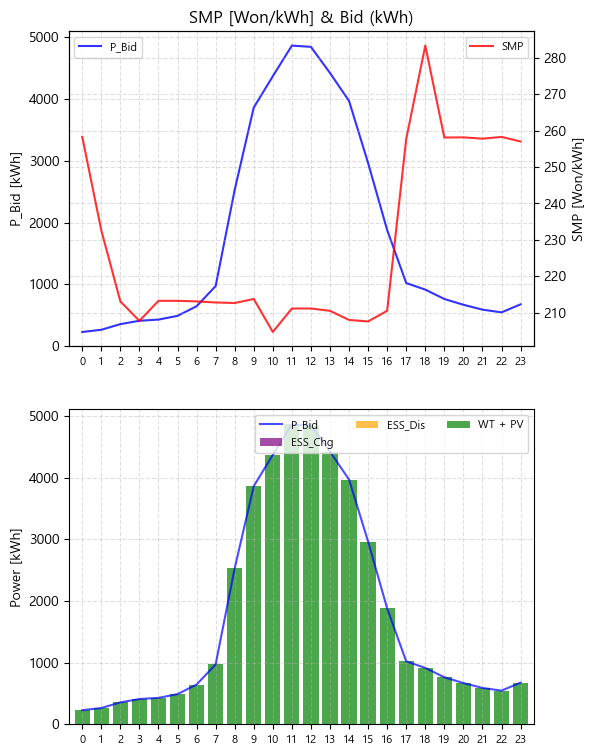

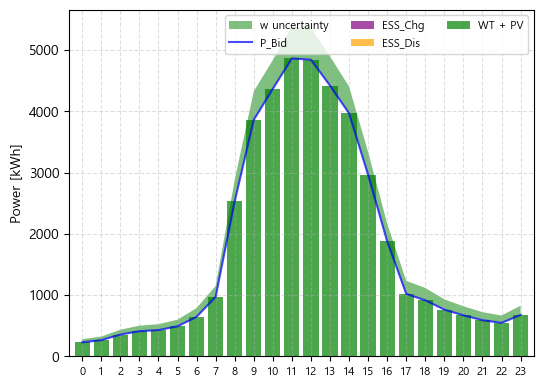

In [10]:
# Draw the Plots
bid_plot_risk_averse = Opt_Bid_Plot(vpp_list, opt_bid_risk_averse, model_dict, case_dict, path)
bid_plot.make_plot(P_dict_risk_averse)

In [11]:
# Check the RES constraint that the method (add_Varaibles) in gurobi_MILP 
# True: add_Variables method - while defining lb, ub in defining variables
# Flase: add_res_contraints method 
check_set = opt_bid_risk_averse.check_res_var_sol(True)

**********
Check_RES_Constaraint_Solution
Check_RES_Constaraint_Solution
Check_RES_Constaraint_Solution
**********
***********
P_wt[i,step], lb, ub, max_power, profile, uncert
var_PWT_lb_ub[0,0]_maxpower_profile_Puncertainty: 226.2192215271765 0.0 1100.0 1000 0.25135469058575166 -0.1
var_PWT_lb_ub[0,1]_maxpower_profile_Puncertainty: 261.5481900166357 0.0 1100.0 1000 0.2906091000184841 -0.1
var_PWT_lb_ub[0,2]_maxpower_profile_Puncertainty: 353.219639851738 0.0 1100.0 1000 0.3924662665019311 -0.1
var_PWT_lb_ub[0,3]_maxpower_profile_Puncertainty: 407.5833487367571 0.0 1100.0 1000 0.4528703874852857 -0.1
var_PWT_lb_ub[0,4]_maxpower_profile_Puncertainty: 426.6443560233872 0.0 1100.0 1000 0.47404928447043027 -0.1
var_PWT_lb_ub[0,5]_maxpower_profile_Puncertainty: 487.24207372240767 0.0 1100.0 1000 0.5413800819137863 -0.1
var_PWT_lb_ub[0,6]_maxpower_profile_Puncertainty: 641.9190396046347 0.0 1100.0 1000 0.713243377338483 -0.1
var_PWT_lb_ub[0,7]_maxpower_profile_Puncertainty: 636.3592143281026

In [12]:
# Check the RES constraint that the method (add_Varaibles) in gurobi_MILP  
lhs, rhs = opt_bid_risk_averse.check_res_const_sol()

Risk_averse_Check_res_const_sol
Risk_averse_Check_res_const_sol
Risk_averse_Check_res_const_sol
risk_averse-check_res_const
(LHS, RHS) - WT + PV 
(226.2192215271765, 276.4901596443268)
(1.205113192818111, 1.3319672131147542)
(0.8034087952120739, 0.8879781420765027)
(261.5481900166357, 319.67001002033254)
(1.1587626854020296, 1.2807377049180328)
(0.7725084569346864, 0.8538251366120219)
(353.219639851738, 431.71289315212425)
(1.0660616705698673, 1.1782786885245902)
(0.7107077803799116, 0.7855191256830601)
(407.5833487367571, 498.15742623381425)
(1.0351613322924798, 1.1441256830601092)
(0.6901075548616532, 0.7627504553734061)
(426.6443560233872, 521.4542129174733)
(1.019711163153786, 1.1270491803278688)
(0.6798074421025241, 0.7513661202185792)
(487.24207372240767, 595.5180901051649)
(1.0351613322924798, 1.1441256830601092)
(0.6901075548616532, 0.7627504553734061)
(641.9190396046347, 784.5677150723312)
(1.3596148842050482, 1.5027322404371584)
(0.9064099228033654, 1.0018214936247722)
(636.3

In [13]:
# Check the bid contraints that the method (add_bid_constraints) in gurobi_MILP 
lhs_bid, rhs_bid = opt_bid_risk_averse.check_bid_const_sol()

check_bid_const_sol
check_bid_const_sol
check_bid_const_sol
(228.2277435152067, 228.2277435152067)
(263.47946115897247, 263.47946115897247)
(354.99640930268777, 354.99640930268777)
(409.30861762391123, 409.30861762391123)
(428.3438746286435, 428.3438746286435)
(488.9673426095618, 488.9673426095618)
(644.1850644116431, 644.1850644116431)
(970.9326270265152, 970.9326270265152)
(2529.8871242845844, 2529.8871242845844)
(3860.9983504657075, 3860.9983504657075)
(4367.816089295241, 4367.816089295241)
(4863.534258835891, 4863.534258835891)
(4843.027833303368, 4843.027833303368)
(4420.161611892351, 4420.161611892351)
(3967.3037054637994, 3967.3037054637994)
(2962.3619401218093, 2962.3619401218093)
(1878.8666366558218, 1878.8666366558218)
(1019.5843091334895, 1019.5843091334895)
(913.9992908197622, 913.9992908197622)
(761.7160323868507, 761.7160323868507)
(668.5321502587775, 668.5321502587775)
(589.3151856957468, 589.3151856957468)
(545.4055925543825, 545.4055925543825)
(675.147039789777, 675.14

In [14]:
# Check the RES constraint that the method (add_res_constraints) in gurobi_MILP 
# True: add_Variables method, 
# Flase: add_res_contraints method 
check_set_const = opt_bid_risk_averse.check_res_var_sol(False)

**********
Check_RES_Constaraint_Solution
Check_RES_Constaraint_Solution
Check_RES_Constaraint_Solution
**********
***********
P_wt[i,step], lb, ub, max_power, profile, uncert
var_PWT_lb_ub[0,0]_maxpower_profile_Puncertainty: 226.2192215271765 0.0 900.0 1000 0.25135469058575166 -0.1
var_PWT_lb_ub[0,1]_maxpower_profile_Puncertainty: 261.5481900166357 0.0 900.0 1000 0.2906091000184841 -0.1
var_PWT_lb_ub[0,2]_maxpower_profile_Puncertainty: 353.219639851738 0.0 900.0 1000 0.3924662665019311 -0.1
var_PWT_lb_ub[0,3]_maxpower_profile_Puncertainty: 407.5833487367571 0.0 900.0 1000 0.4528703874852857 -0.1
var_PWT_lb_ub[0,4]_maxpower_profile_Puncertainty: 426.6443560233872 0.0 900.0 1000 0.47404928447043027 -0.1
var_PWT_lb_ub[0,5]_maxpower_profile_Puncertainty: 487.24207372240767 0.0 900.0 1000 0.5413800819137863 -0.1
var_PWT_lb_ub[0,6]_maxpower_profile_Puncertainty: 641.9190396046347 0.0 900.0 1000 0.713243377338483 -0.1
var_PWT_lb_ub[0,7]_maxpower_profile_Puncertainty: 636.3592143281026 0.0 90